In [166]:
    # Importaciones de Sistema Operativo y Glob
import os 
from glob import glob

In [167]:
    #Definimos el Path del Dataset
base_dir = "./Dataset"

In [168]:
def create_image_labels_dict(dir):
    image_label_dict = {}
    for label_dir in os.listdir(dir):
        full_label_dir = os.path.join(dir, label_dir)
        for img_path in glob(full_label_dir + "/*.png"):
            image_label_dict[img_path] = label_dir
    return image_label_dict

ds = create_image_labels_dict(base_dir)

In [169]:
        # IMPORTS
    # Para cargar imágenes
from PIL import Image
    # Para manejar tensores
import torch

    #Para manejar la métrica
import numpy as np
from datasets import load_metric

In [170]:
from PIL import Image
from transformers import AutoProcessor
  #processor
processor = AutoProcessor.from_pretrained("lokeshk/Face-Recognition-NM")

C:\Users\ferna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [171]:


    #Hacemos un shuffle a ds:
import random
random.seed(42)

ds = dict(random.sample(ds.items(), len(ds)))

C:\Users\ferna\AppData\Local\Temp\ipykernel_17276\1834675470.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  ds = dict(random.sample(ds.items(), len(ds)))


In [172]:
  # Función para cargar imágenes y sus etiquetas usando el diccionario
def load_images_from_dict(image_label_dict):
    images = []
    labels = []
    label_to_id = {label: idx for idx, label in enumerate(set(image_label_dict.values()))}

    for img_path, label in image_label_dict.items():
        image = Image.open(img_path).convert("RGB")  # Asegura que las imágenes tengan 3 canales en orden RGB
        inputs = processor(images=image, return_tensors="pt")
        images.append(inputs['pixel_values'].squeeze(0))  # Ajuste aquí para asegurar que sea un tensor 3D
        labels.append(label_to_id[label])

    return images, labels  # Devuelve listas simples para evitar problemas de dimensionamiento

images, labels = load_images_from_dict(ds)

  # Verifica la carga de datos
print(f"Total de imágenes cargadas: {len(images)}")
print(f"Primeras 5 etiquetas: {labels[:5]}")    # Seteamos el diccionario de Imágenes y Labels

Total de imágenes cargadas: 416
Primeras 5 etiquetas: [1, 0, 0, 1, 0]


Screenshot


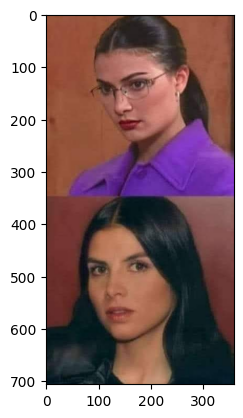

In [173]:
#     #Por seguimiento del proceso
#   #Mostremos la primer imagen, Y su etiqueta
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# img = mpimg.imread(list(ds.keys())[30])
# imgplot = plt.imshow(img)
# print(ds[list(ds.keys())[30]])

In [174]:
  # Crear un dataset con los tensores
from datasets import Dataset
dataset = Dataset.from_dict({"pixel_values": images, "labels": labels})

In [175]:
  # Dividir el dataset en entrenamiento y validación (80% entrenamiento, 20% validación)
train_testsplit = dataset.train_test_split(test_size=0.2)
train_dataset = train_testsplit['train']
eval_dataset = train_testsplit['test']

In [176]:
    # Importamos el Modelo
from transformers import ViTForImageClassification
repo_id = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(
    repo_id,
    num_labels=len(set(labels)),
    id2label={id: label for id, label in enumerate(set(labels))},
    label2id={label: id for id, label in enumerate(set(labels))},
    ignore_mismatched_sizes=True
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [177]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="Screenshots_detection_to_classification",
    eval_strategy="steps",
    num_train_epochs=4,
    learning_rate=2e-4,
    remove_unused_columns=False,
    push_to_hub=True,
    load_best_model_at_end=True,
)

In [178]:
import numpy as np

# Definir la función de collation
def collate_fn(batch):
    return {
        "pixel_values": torch.stack([torch.tensor(item["pixel_values"]) for item in batch]),
        "labels": torch.tensor([item["labels"] for item in batch])
    }
  # Definir la función para calcular métricas
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    acc = (preds == p.label_ids).mean()
    return {"accuracy": acc}

In [179]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

In [180]:
train_results = trainer.train()

100%|██████████| 168/168 [03:08<00:00,  1.12s/it]


{'train_runtime': 188.7378, 'train_samples_per_second': 7.036, 'train_steps_per_second': 0.89, 'train_loss': 0.11647429920378186, 'epoch': 4.0}


In [181]:
eval_results = trainer.evaluate(eval_dataset)
print(f"Accuracy: {eval_results['eval_accuracy']}")

100%|██████████| 11/11 [00:07<00:00,  1.50it/s]

Accuracy: 0.9880952380952381


## Vamos con toda la lógica para comprobar las predicciones

In [182]:
text_labels = set(ds.values())
print(text_labels)

{'Photo', 'Screenshot'}


In [183]:
    #Obtenemos todaslas etiquetas únicas y mapearlas a IDs
unique_labels = list(text_labels)
label_to_id = {label: id for id, label in enumerate(unique_labels)}
id_to_label = {id: label for label, id in label_to_id.items()}

    #Verificamos el mapeo
print("Label to ID mapping:", label_to_id)
print("ID to Label mapping:", id_to_label)

    #Guardamos el mapeo en un archivo

Label to ID mapping: {'Photo': 0, 'Screenshot': 1}
ID to Label mapping: {0: 'Photo', 1: 'Screenshot'}


## Predicciones

In [184]:
    #   Hagamos las predicciones, 1 por una. Una función que reciba una imagen y devuelva la etiqueta predicha
def predict_image_label(image):
     output = model(pixel_values=image).logits
     predicted_label_id = output.argmax(-1).item()
     predicted_label = id_to_label[predicted_label_id]
     return predicted_label

In [185]:
def predict_test_images():
        #Obtengamos todas las imágenes dentro de la carpeta test_images
    test_image_dir = "./test_images"
    test_images = [Image.open(os.path.join(test_image_dir, img)).convert("RGB") for img in os.listdir(test_image_dir)]

        # Procesar las imágenes
    test_processed_images = processor(images=test_images, return_tensors="pt")
    test_pixel_values = test_processed_images['pixel_values']


        #   Move the model to the GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    test_pixel_values = test_pixel_values.to(device)

        #   Hacer predicciones para todas las imágenes
    predictions = [predict_image_label(image.unsqueeze(0)) for image in test_pixel_values]

        #   Además de devolver las predicciones y las imágenes, devolvamos la ruta de las imágenes
    rutas = [os.path.join(test_image_dir, img) for img in os.listdir(test_image_dir)]

    return predictions, test_images, rutas


## Guardamos El Modelo

In [186]:
trainer.save_model("Screenshots_detection_to_classification")

trainer.log_metrics("eval", eval_results)
trainer.save_metrics("eval", eval_results)

trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

trainer.save_state()

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9881
  eval_loss               =     0.1192
  eval_runtime            = 0:00:09.08
  eval_samples_per_second =      9.245
  eval_steps_per_second   =      1.211
***** train metrics *****
  epoch                    =        4.0
  total_flos               = 95841812GF
  train_loss               =     0.1165
  train_runtime            = 0:03:08.73
  train_samples_per_second =      7.036
  train_steps_per_second   =       0.89


In [187]:
kwargs = {
    "finetuned_from": repo_id,
    "tasks": "image-classification",
    "dataset": "private_images_dataset",
    "tags": "image-classification, screenshots detection",
}

trainer.push_to_hub(**kwargs)

CommitInfo(commit_url='https://huggingface.co/al-css/Screenshots_detection_to_classification/commit/75c04f72e8bf29ac715e84d69c9c632f9ced8247', commit_message='End of training', commit_description='', oid='75c04f72e8bf29ac715e84d69c9c632f9ced8247', pr_url=None, pr_revision=None, pr_num=None)

 # Vamos a la Acción

In [188]:
    # Tomemos todas las imágenes en test_images y hagamos predicciones
predictions, test_images, rutas = predict_test_images()

In [189]:
predictions

['Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Screenshot',
 'Photo',
 'Photo',
 'Photo',
 'Screenshot',
 'Photo',
 'Screenshot',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Screenshot',
 'Photo',
 'Photo',
 'Photo',
 'Screenshot',
 'Photo',
 'Photo',
 'Photo',
 'Screenshot',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Screenshot',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Pho

In [190]:
predictions

['Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Screenshot',
 'Photo',
 'Photo',
 'Photo',
 'Screenshot',
 'Photo',
 'Screenshot',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Screenshot',
 'Photo',
 'Photo',
 'Photo',
 'Screenshot',
 'Photo',
 'Photo',
 'Photo',
 'Screenshot',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Screenshot',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Photo',
 'Pho

In [191]:
    # En un archivo, quiero que se enlisten las rutas de las imágenes que fueron predichas como "screenshot"
with open("screenshot_predictions.txt", "w") as f:
     for ruta, predictions in zip(rutas, predictions):
        if predictions == "Screenshot":
                # Remplazamos el \ por / para que sea compatible con Windows
            ruta = ruta.replace("\\", "/")
            f.write(ruta + "\n")
            print(ruta)


./test_images\00005.png
./test_images\00010.png
./test_images\00012.png
./test_images\00079.png
./test_images\00083.png
./test_images\00087.png
./test_images\00092.png
./test_images\00120.png
./test_images\00132.png
./test_images\00157.png
./test_images\00163.png
./test_images\00178.png
./test_images\00182.png
./test_images\00186.png
./test_images\00192.png
./test_images\00196.png
./test_images\00201.png
./test_images\00225.png
./test_images\00227.png
./test_images\00238.png
./test_images\00243.png
./test_images\00248.png
./test_images\00253.png
./test_images\00255.png
./test_images\00261.png
./test_images\00262.png
./test_images\00263.png
./test_images\00273.png
./test_images\00274.png
./test_images\00291.png
./test_images\00292.png
./test_images\00297.png
./test_images\00306.png
./test_images\00327.png
./test_images\00345.png
./test_images\00373.png
./test_images\00384.png
./test_images\00388.png
./test_images\00397.png
./test_images\00413.png
./test_images\00419.png
./test_images\00